# Final Pipeline for SSD Mobilenet 

### Preparing Data

First to prepare **Boilerplate** code, which typically involve loading the data.

In [ ]:
# getting GPU info
!nvidia-smi

Wed Feb  3 16:57:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# IMPORTANT : make sure to use Tensorflow version 1.x, now Tensorflow's team updated the API, so it can work with Tensorflow 2.x also
# but here I used Tensorflow 1.x implementation
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# setting path to root
%cd

# inside /root
# cloning Tensorflow's model repository to colab
!git clone https://github.com/tensorflow/models.git

/root
Cloning into 'models'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 51358 (delta 49), reused 60 (delta 13), pack-reused 51252
Receiving objects: 100% (51358/51358), 568.90 MiB | 38.50 MiB/s, done.
Resolving deltas: 100% (35029/35029), done.


In [ ]:
# setting new path
%cd /root/models/research/

# inside /root/models/research/
# PROTOBUF compilation
# The Tensorflow Object Detection API uses Protobufs to configure model and training parameters
# Before the framework can be used, the Protobuf libraries must be compiled.
!protoc object_detection/protos/*.proto --python_out=.

# Check for the current route
!pwd

/root/models/research
/root/models/research


In [ ]:
# still inside /root/models/research/
# adding libraries to the python path

import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/:/root/models/research/object_detection/utils/:/root/models/research/object_detection'

In [ ]:
# tf_slim necessary to install
!pip install tf_slim

     |████████████████████████████████| 358kB 18.1MB/s 


In [ ]:
!pip install lvis

## Data Loading

In [ ]:
# copying zip file to google colab

!cp -r '/content/drive/MyDrive/RDD/data.tar.gz' '/root/models/'

In [ ]:
# setting new path
%cd /root/models/

# unzipping the zipped file
!tar -xvf  'data.tar.gz'

Streaming output truncated to the last 5000 lines.
data/images/train/Japan_000829.xml
data/images/train/Japan_008427.xml
data/images/train/Japan_003047.jpg
data/images/train/Japan_012361.jpg
data/images/train/Japan_000291.jpg
data/images/train/India_007122.jpg
data/images/train/Japan_005137.jpg
data/images/train/Japan_001859.jpg
data/images/train/Japan_000577.xml
data/images/train/Japan_010791.jpg
data/images/train/Japan_000484.xml
data/images/train/Japan_000225.jpg
data/images/train/Japan_001364.jpg
data/images/train/Japan_006388.jpg
data/images/train/Japan_012196.xml
data/images/train/Czech_002165.xml
data/images/train/Japan_011783.jpg
data/images/train/Japan_012810.xml
data/images/train/India_006094.jpg
data/images/train/Japan_001065.jpg
data/images/train/Japan_010245.jpg
data/images/train/Czech_000995.xml
data/images/train/Japan_011435.xml
data/images/train/Japan_000889.jpg
data/images/train/Japan_006283.xml
data/images/train/Japan_006561.xml
data/images/train/Czech_003348.xml
data

In [ ]:
# importing some important libraries
import pandas as pd

import imgaug as ia
ia.seed(1)

import imageio

from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 

import glob
import cv2

### Copying saved trained graph 

In [ ]:
# creating empty directory to keep saved trained graph
os.mkdir('/root/models/fine_tuned_model')
# creating empty directory to keep pbtxt file
os.mkdir('/root/models/data/annotations')

In [ ]:
# copying saved trained graph
!cp -r '/content/drive/MyDrive/RDD/Mobilenet/frozen_inference_graph.pb' '/root/models/fine_tuned_model'
# copying saved pbtxt file
!cp -r '/content/drive/MyDrive/RDD/Mobilenet/label_map.pbtxt' '/root/models/data/annotations'
# copying saved test saved csv file
!cp -r '/content/drive/MyDrive/RDD/Mobilenet/test_labels.csv' '/root/models/data/annotations'

In [ ]:
!pip install tensorflow-object-detection-api

     |████████████████████████████████| 583kB 17.3MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 2.6MB 52.6MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-cp36-none-any.whl size=844516 sha256=a3e2a3dbda186e91af3246a7706074dd08f500802f19a5730dd5e2c806413038
  Stored in directory: /root/.cache/pip/wheels/4a/54/d0/cfca11930c4b2025d40dede77059094070a67cc3e7bd3b285f
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3854b1db427e9965a0a96d6e212ceb3aa7f779b78c8f7fc7c8517e36bec98617
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built tensorflow-object-detection-api gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [ ]:
# importing more libraries for prediction
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
# This is needed to display the images.
%matplotlib inline

In [ ]:
# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/models/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/root/models/data/annotations/label_map.pbtxt'

NUM_CLASSES = 4

In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [ ]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

print(category_index)

{1: {'id': 1, 'name': 'D00'}, 2: {'id': 2, 'name': 'D10'}, 3: {'id': 3, 'name': 'D20'}, 4: {'id': 4, 'name': 'D40'}}


In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [ ]:
# creating a list of the names of all the test images
test_images = []
for filename in os.listdir("/root/models/data/images/test"):
  if filename.split('.')[-1] == 'jpg':
    test_images.append(filename)

print(len(test_images))

2439


In [ ]:
import pandas as pd

test_labels = pd.read_csv('/root/models/data/annotations/test_labels.csv')
test_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,India_003754.jpg,720,720,D20,76,513,720,618
1,Japan_004285.jpg,600,600,D00,250,339,304,457
2,Japan_003888.jpg,600,600,D00,344,364,460,524
3,Japan_003888.jpg,600,600,D10,28,405,452,470
4,Japan_003888.jpg,600,600,D20,175,285,208,322


## Final Detection Pipeline

In [ ]:
def final(test_imgs):
  for image_path in test_imgs:

    # for original image
    grouped = test_labels.groupby('filename')
    group_df = grouped.get_group(image_path)
    group_df = group_df.reset_index()
    group_df = group_df.drop(['index'], axis=1)
    bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    img_arr = imageio.imread('/root/models/data/images/test/' + image_path)
    bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=img_arr.shape)

    # for predicted image
    image = Image.open('/root/models/data/images/test/' + image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=4)
    
    plt.figure(figsize=(12,7))
    plt.subplot(121)
    plt.title('Original Image')
    plt.imshow(bbs.draw_on_image(img_arr, size=1))

    plt.subplot(122)
    plt.title('Predicted Image')
    plt.imshow(image_np)

### Prediction for single image

In [ ]:
import random

# taking a random test image
TEST_IMAGE_PATHS = random.sample(test_images, 1)
TEST_IMAGE_PATHS

['Japan_012719.jpg']

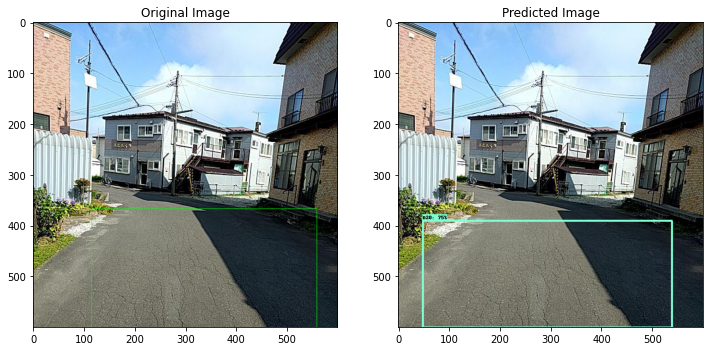

In [ ]:
# calling the final pipeline function
final(TEST_IMAGE_PATHS)

### Prediction for multiple images

In [ ]:
import random

# taking 10 random test images
TEST_IMAGE_PATHS = random.sample(test_images, 10)
TEST_IMAGE_PATHS

['Japan_010747.jpg',
 'Czech_002701.jpg',
 'Japan_007495.jpg',
 'Japan_007081.jpg',
 'India_007985.jpg',
 'Japan_012044.jpg',
 'Japan_003172.jpg',
 'India_004393.jpg',
 'Japan_001484.jpg',
 'Japan_011152.jpg']

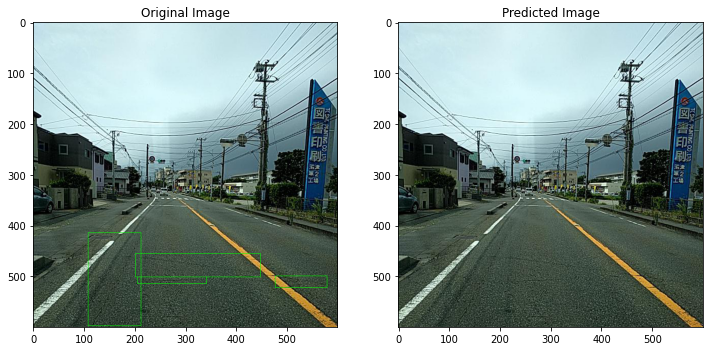

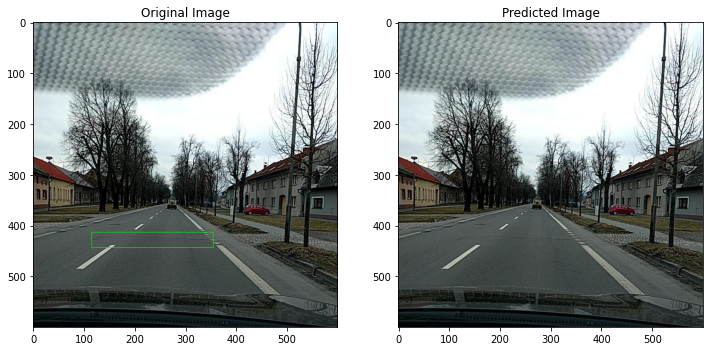

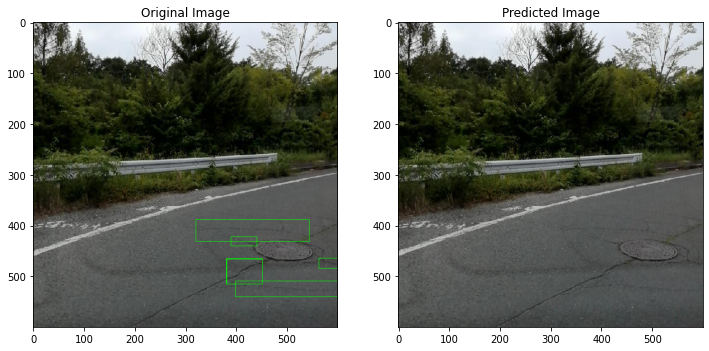

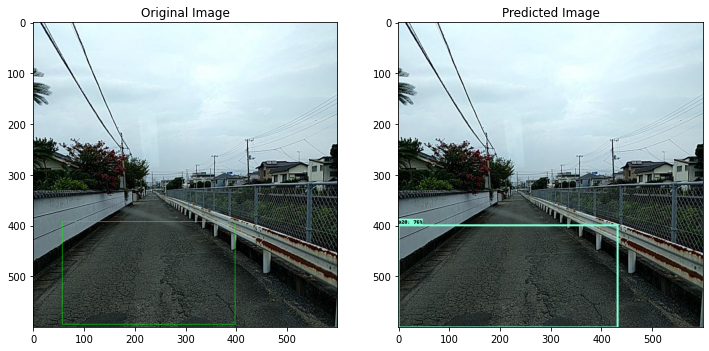

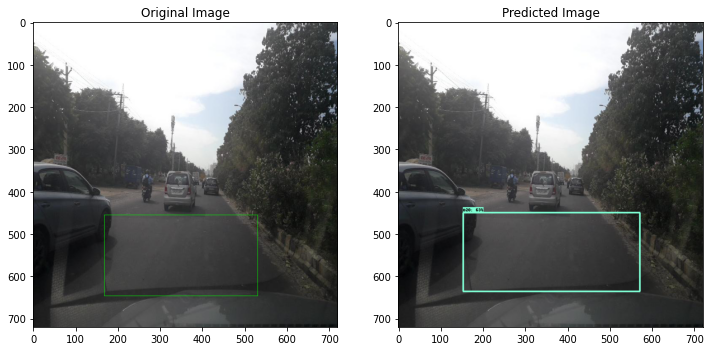

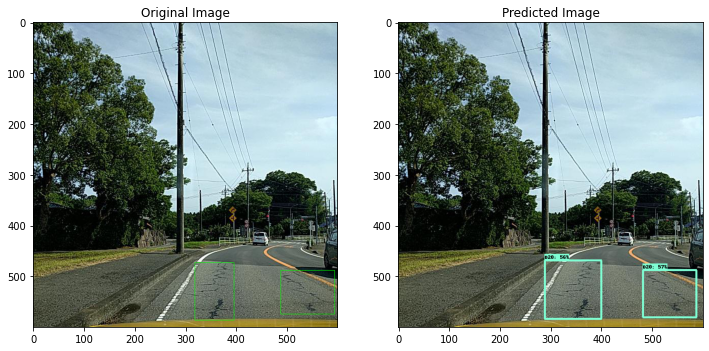

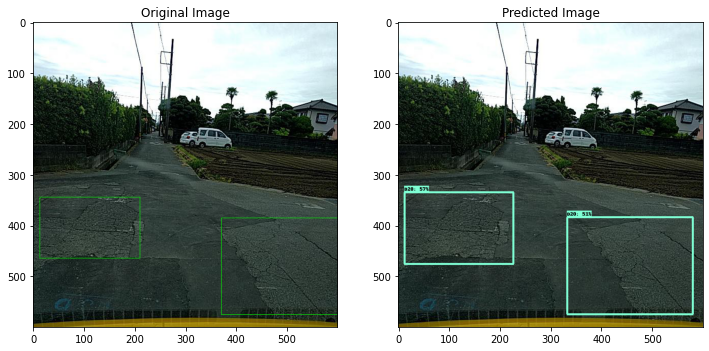

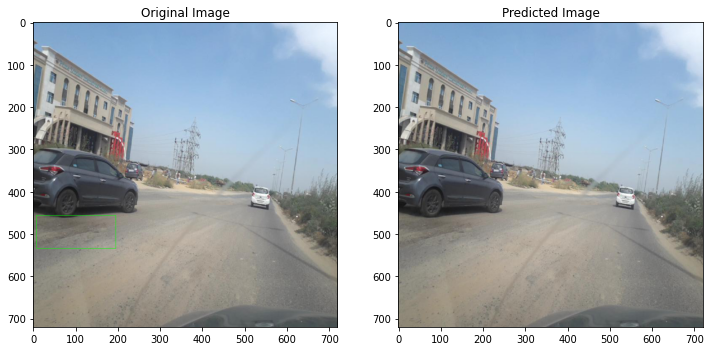

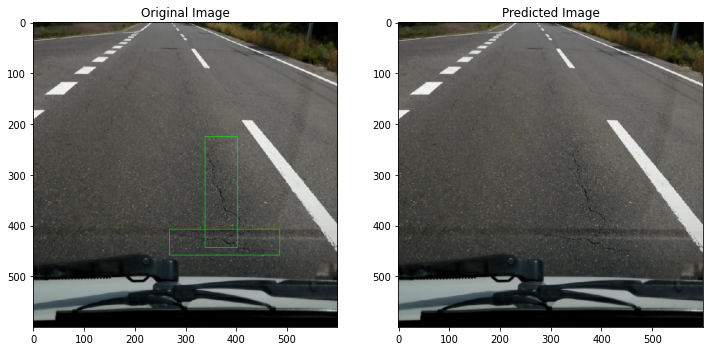

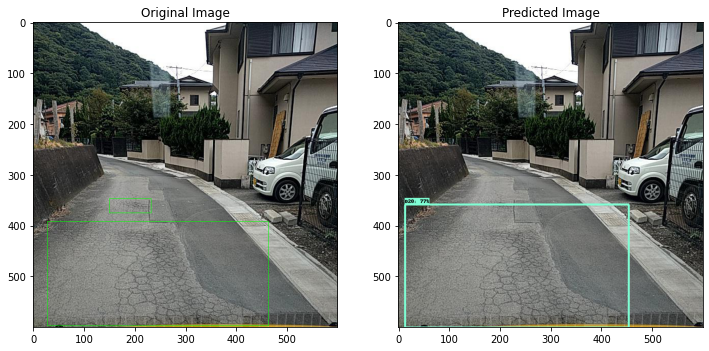

In [ ]:
# calling the final pipeline function
final(TEST_IMAGE_PATHS)

## Conclusion - 

This SSD Mobilenet model is not working as good as YOLO v3, so it need a lot of improvement. For some of the damage categories specially for D20 it is predicting very well, but for the rest of the categories it fails(not everytime). 

## Future Work - 

1. Since I worked in the Google Colab, where with the GPU we have time restrictions. So training of this model for more epochs can improve the detection accuracy.
2. Need some more data, for that I have already augumented images. But to train with these many images can exhaust our limited resources. So in future this will be another work to perform.